In [1]:
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil

from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
rs =  RobustScaler(quantile_range=(10.0, 90.0))
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(0,1))
pts = PowerTransformer()
scaler = StandardScaler()

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from sklearn.decomposition import PCA

In [2]:
gdf = gpd.read_file(f"zip://statistical-gis-boundaries-london.zip!statistical-gis-boundaries-london/ESRI/London_Ward_CityMerged.shp")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        625 non-null    object  
 1   GSS_CODE    625 non-null    object  
 2   HECTARES    625 non-null    float64 
 3   NONLD_AREA  625 non-null    float64 
 4   LB_GSS_CD   625 non-null    object  
 5   BOROUGH     625 non-null    object  
 6   POLY_ID     625 non-null    int64   
 7   geometry    625 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 39.2+ KB


In [3]:
df = pd.read_csv('London_Ward_wellbeing_indicators.csv',
                 encoding= 'utf-8', na_values=[':'], low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663 entries, 0 to 662
Data columns (total 64 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Old Ward Code                                                      659 non-null    object 
 1   New ward code                                                      659 non-null    object 
 2   Ward                                                               657 non-null    object 
 3   Borough                                                            660 non-null    object 
 4   Life Expectancy 2005-2009                                          661 non-null    object 
 5   Life Expectancy 2006-2010                                          660 non-null    float64
 6   Life Expectancy 2007-11                                            660 non-null    float64
 7   Life Expectancy 2008-12   

In [5]:
df = df[['New ward code','Life Expectancy 2009-13','Incapacity Benefit rate - 2013','Unemployment rate 2013',
         'Crime rate - 2013','Deliberate Fires - 2013','% dependent children in out-of-work households - 2013',
         'Public Transport Accessibility - 2013']]
df.head()

,New ward code,Life Expectancy 2009-13,Incapacity Benefit rate - 2013,Unemployment rate 2013,Crime rate - 2013,Deliberate Fires - 2013,% dependent children in out-of-work households - 2013,Public Transport Accessibility - 2013
0,E09000001,86.4,0.8,2.2,14.0,0.3,10.0,7.9
1,E05000026,82.0,1.6,8.9,120.8,1.2,25.0,6.0
2,E05000027,79.0,3.2,10.2,93.2,0.7,32.0,3.1
3,E05000028,79.2,2.3,9.9,104.7,0.4,32.0,2.9
4,E05000029,80.8,2.6,8.6,83.7,1.9,28.0,2.3


In [6]:
df.columns = ['code','life_expect','incapacity_benefit','unemployment','crime','fires','child_in_poverty','PTAL']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663 entries, 0 to 662
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   code                659 non-null    object 
 1   life_expect         660 non-null    float64
 2   incapacity_benefit  660 non-null    float64
 3   unemployment        660 non-null    float64
 4   crime               660 non-null    float64
 5   fires               659 non-null    float64
 6   child_in_poverty    660 non-null    float64
 7   PTAL                659 non-null    float64
dtypes: float64(7), object(1)
memory usage: 41.6+ KB


In [7]:
pd.isnull(df).sum() > 0

code                  True
life_expect           True
incapacity_benefit    True
unemployment          True
crime                 True
fires                 True
child_in_poverty      True
PTAL                  True
dtype: bool

In [8]:
print(df[df['life_expect'].isnull()])

    code  life_expect  incapacity_benefit  unemployment  crime  fires  \
660  NaN          NaN                 NaN           NaN    NaN    NaN   
661  NaN          NaN                 NaN           NaN    NaN    NaN   
662  NaN          NaN                 NaN           NaN    NaN    NaN   

     child_in_poverty  PTAL  
660               NaN   NaN  
661               NaN   NaN  
662               NaN   NaN  


In [9]:
print(df.shape)

df = df.dropna()

print(df.shape)

(663, 8)
(658, 8)


In [10]:
df.head()

,code,life_expect,incapacity_benefit,unemployment,crime,fires,child_in_poverty,PTAL
0,E09000001,86.4,0.8,2.2,14.0,0.3,10.0,7.9
1,E05000026,82.0,1.6,8.9,120.8,1.2,25.0,6.0
2,E05000027,79.0,3.2,10.2,93.2,0.7,32.0,3.1
3,E05000028,79.2,2.3,9.9,104.7,0.4,32.0,2.9
4,E05000029,80.8,2.6,8.6,83.7,1.9,28.0,2.3


In [11]:
df1 = pd.read_csv('https://data.london.gov.uk/download/ward-profiles-and-atlas/772d2d64-e8c6-46cb-86f9-e52b4c7851bc/ward-profiles-excel-version.csv',
                 encoding= 'unicode_escape', na_values=[':'], low_memory=False)

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 67 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Ward name                                                                    660 non-null    object 
 1   Old code                                                                     660 non-null    object 
 2   New code                                                                     660 non-null    object 
 3   Population - 2015                                                            660 non-null    float64
 4   Children aged 0-15 - 2015                                                    660 non-null    float64
 5   Working-age (16-64) - 2015                                                   660 non-null    float64
 6   Older people aged 65+ - 2015              

In [13]:
df1 = df1[['New code','% travel by bicycle to work - 2011']]
df1.head()

,New code,% travel by bicycle to work - 2011
0,E09000001,5.3
1,E05000026,0.8
2,E05000027,1.0
3,E05000028,1.6
4,E05000029,1.2


In [14]:
df1.columns = ['new_code','Cycle_to_Work']
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   new_code       660 non-null    object 
 1   Cycle_to_Work  660 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.4+ KB


In [15]:
pd.isnull(df1).sum() > 0

new_code         False
Cycle_to_Work    False
dtype: bool

In [16]:
print(df1.shape)

df1 = df1.dropna()

print(df1.shape)

(660, 2)
(660, 2)


In [17]:
df1.sample()

,new_code,Cycle_to_Work
37,E05000062,1.3


In [18]:
pdmerge = pd.merge(df, df1, left_on='code', right_on='new_code', how='inner')
pdmerge.shape
pdmerge.sample(3)

,code,life_expect,incapacity_benefit,unemployment,crime,fires,child_in_poverty,PTAL,new_code,Cycle_to_Work
333,E05000357,81.6,2.0,7.0,83.4,0.9,22.0,2.3,E05000357,1.2
515,E05000539,82.3,1.8,4.6,93.3,0.0,12.0,4.1,E05000539,8.9
66,E05000090,82.4,1.4,5.3,67.7,0.1,13.0,2.8,E05000090,1.1


In [19]:
ppd = pd.merge(gdf, pdmerge, left_on='GSS_CODE', right_on='code', how='inner').reset_index()
ppd.shape
ppd.sample(3)

,index,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,code,life_expect,incapacity_benefit,unemployment,crime,fires,child_in_poverty,PTAL,new_code,Cycle_to_Work
117,117,Harold Wood,E05000312,758.973,0.0,E09000016,Havering,116699,"POLYGON ((557409.700 190379.900, 557359.800 19...",E05000312,81.6,2.2,4.8,61.0,0.7,14.0,2.4,E05000312,0.8
125,125,West Drayton,E05000342,349.070,0.0,E09000017,Hillingdon,116720,"POLYGON ((507477.500 178781.400, 507460.400 17...",E05000342,79.1,2.3,5.2,92.3,1.4,27.0,2.4,E05000342,1.9
430,430,Graveney,E05000616,101.117,0.0,E09000032,Wandsworth,122407,"POLYGON ((528059.600 170890.400, 528054.000 17...",E05000616,82.1,1.5,5.0,124.1,0.0,22.0,5.2,E05000616,5.5


In [20]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

In [21]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

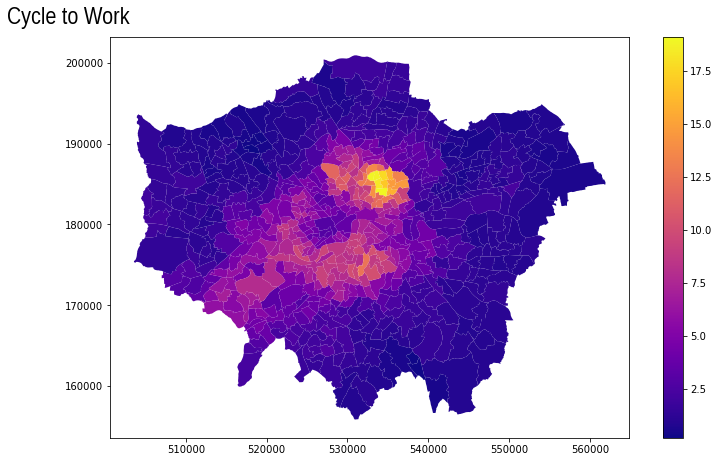

In [22]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
ppd.plot(column='Cycle_to_Work', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"Cycle to Work", x=0.025, size=24, **tfont);
#plt.savefig('Cluster_IMD_Score_Raw.png', dpi=150)

In [23]:
ppd = ppd[['NAME','GSS_CODE','geometry','life_expect','incapacity_benefit','unemployment','crime','fires','child_in_poverty','PTAL','Cycle_to_Work']].copy()
ppd.head()

,NAME,GSS_CODE,geometry,life_expect,incapacity_benefit,unemployment,crime,fires,child_in_poverty,PTAL,Cycle_to_Work
0,Chessington South,E05000405,"POLYGON ((516401.600 160201.800, 516407.300 16...",83.5,1.0,2.1,47.1,0.2,15.0,2.4,2.3
1,Tolworth and Hook Rise,E05000414,"POLYGON ((517829.600 165447.100, 517837.100 16...",83.5,0.6,2.6,46.4,0.4,12.0,2.3,2.9
2,Berrylands,E05000401,"POLYGON ((518107.500 167303.400, 518114.300 16...",81.2,1.1,2.3,36.2,0.2,7.0,2.8,4.6
3,Alexandra,E05000400,"POLYGON ((520480.000 166909.800, 520490.700 16...",85.2,0.6,2.1,43.9,0.2,7.0,2.2,3.9
4,Beverley,E05000402,"POLYGON ((522071.000 168144.900, 522063.900 16...",81.3,1.4,2.9,67.8,0.5,11.0,2.8,4.4


In [24]:
to_cluster = ppd[['GSS_CODE','life_expect','incapacity_benefit','unemployment','crime','fires','child_in_poverty','PTAL','Cycle_to_Work']].set_index('GSS_CODE').copy()
to_cluster.head()

,life_expect,incapacity_benefit,unemployment,crime,fires,child_in_poverty,PTAL,Cycle_to_Work
GSS_CODE,,,,,,,,
E05000405,83.5,1.0,2.1,47.1,0.2,15.0,2.4,2.3
E05000414,83.5,0.6,2.6,46.4,0.4,12.0,2.3,2.9
E05000401,81.2,1.1,2.3,36.2,0.2,7.0,2.8,4.6
E05000400,85.2,0.6,2.1,43.9,0.2,7.0,2.2,3.9
E05000402,81.3,1.4,2.9,67.8,0.5,11.0,2.8,4.4


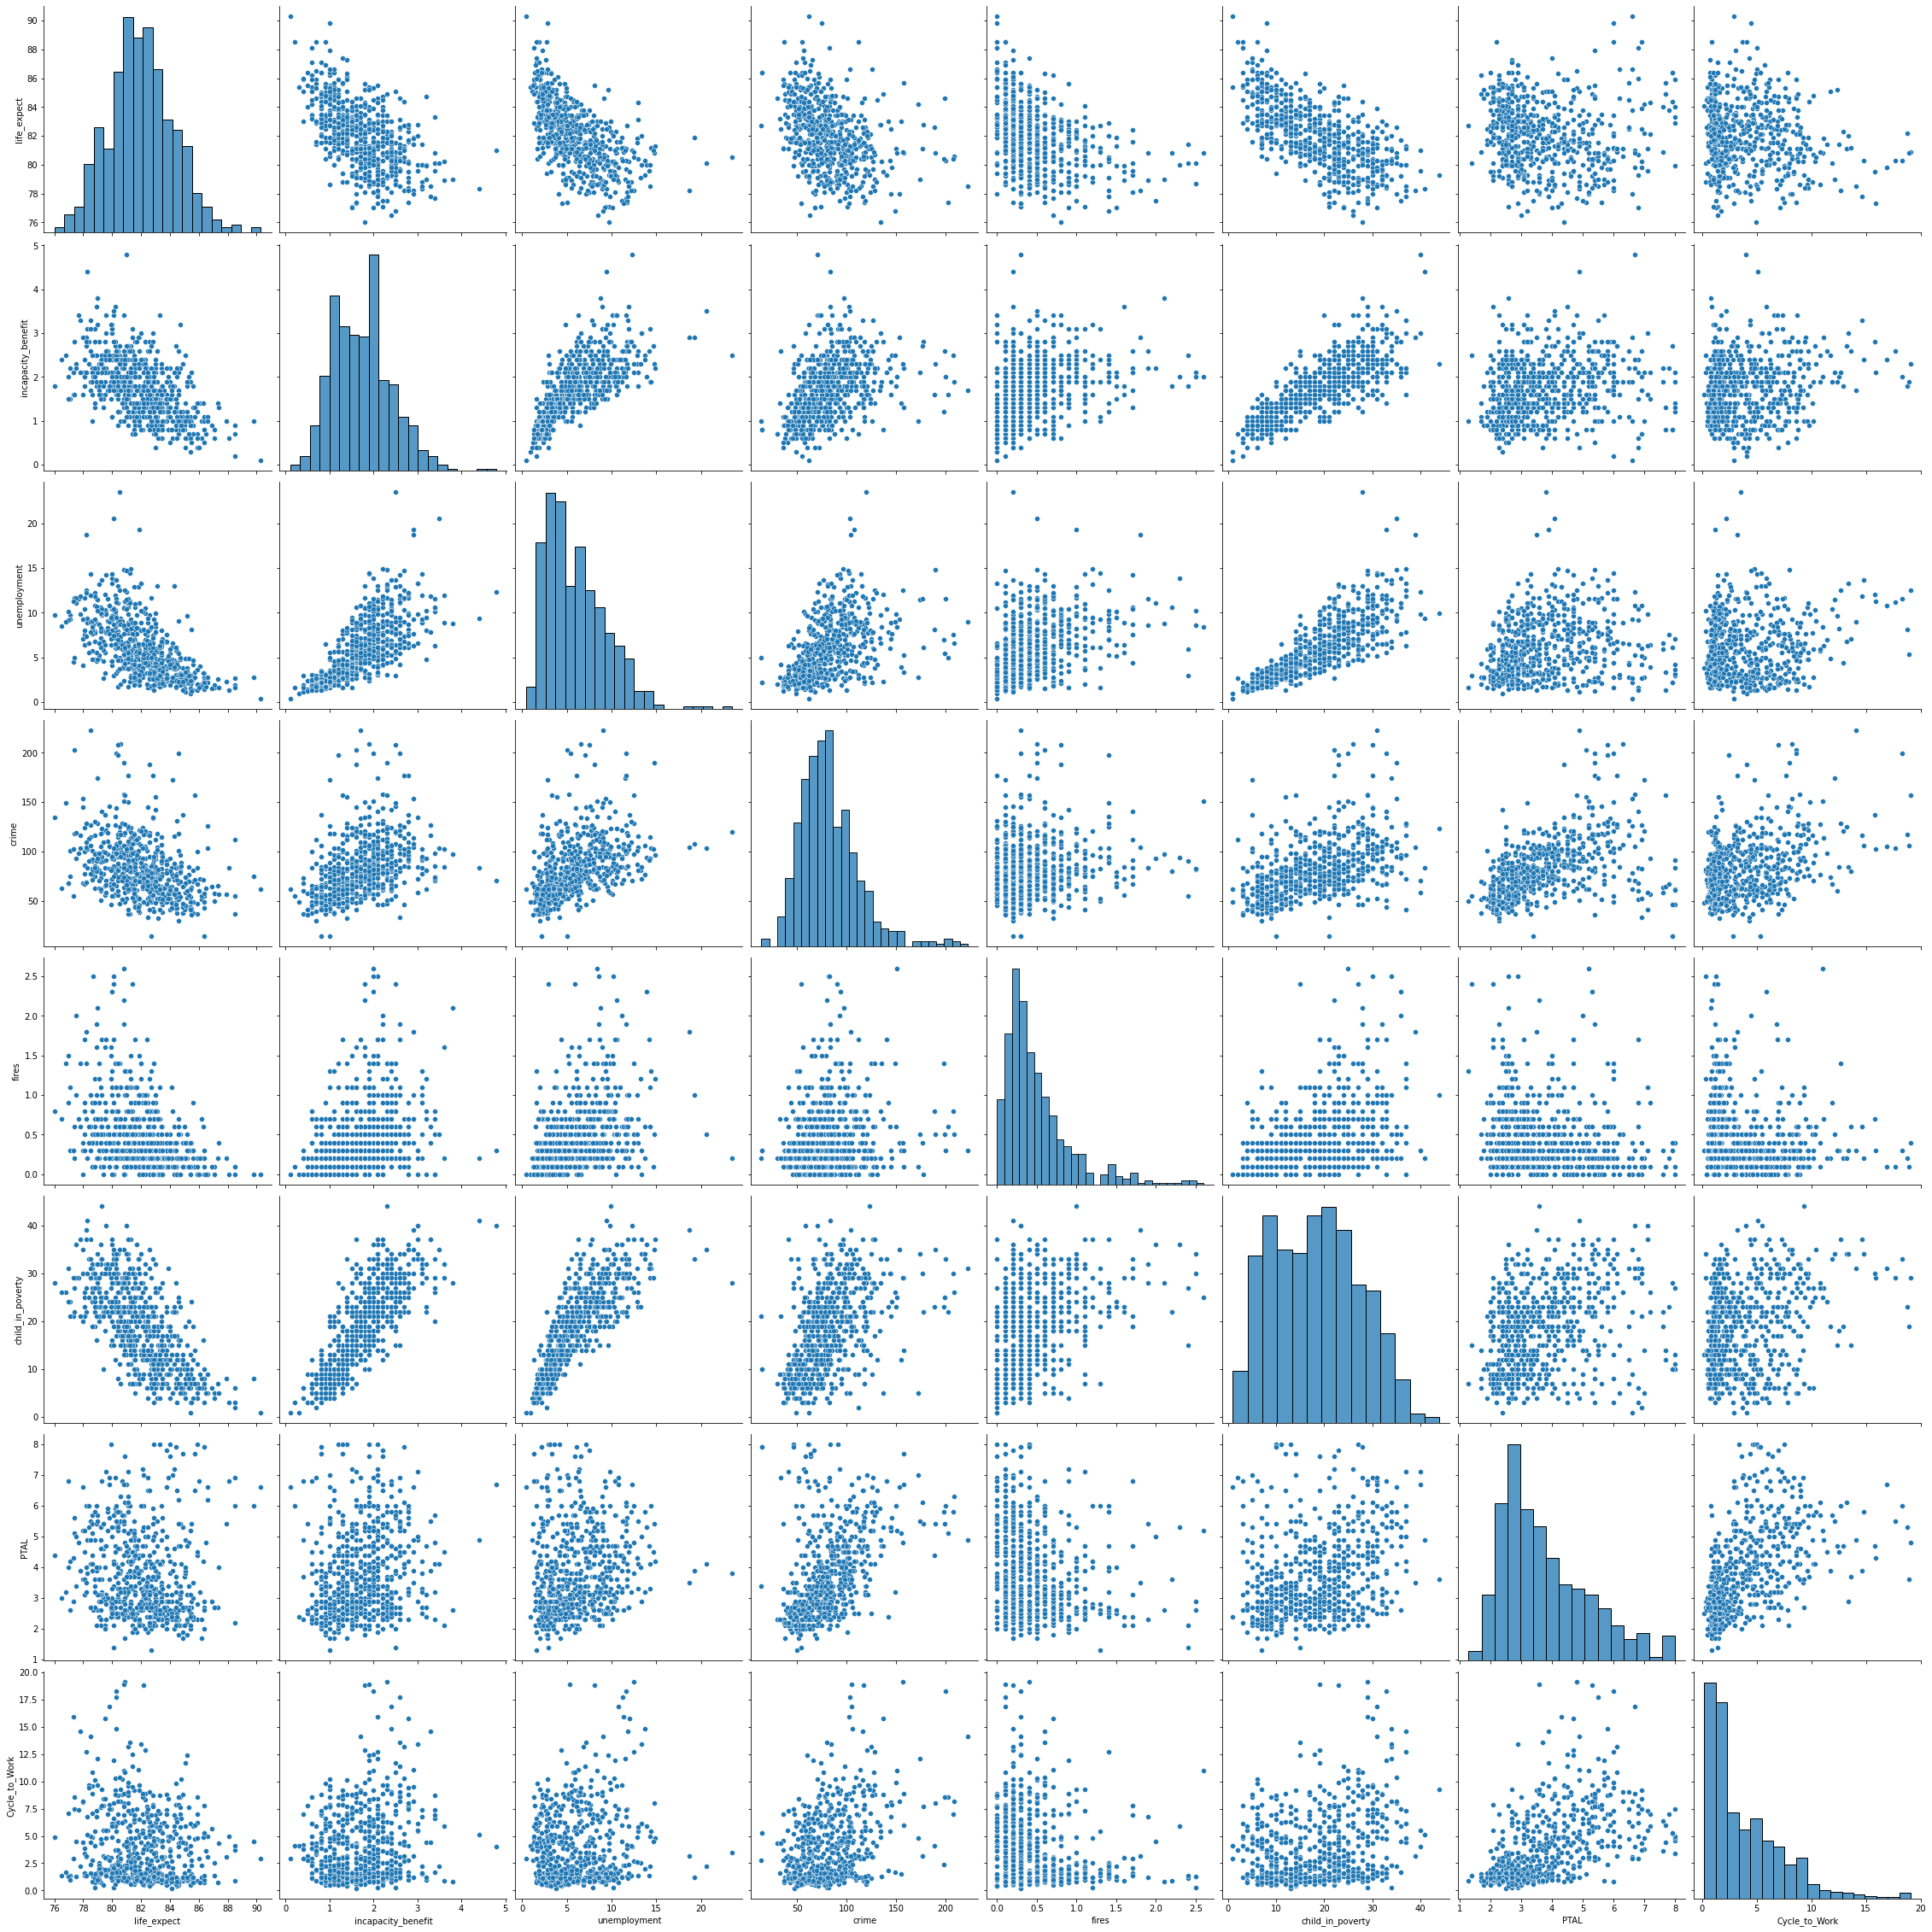

In [25]:
plot_norm = sns.pairplot(to_cluster,height = 4)

In [26]:
normed = to_cluster.copy()
for c in to_cluster.columns.values:
    normed[c] = pts.fit_transform(to_cluster[c].values.reshape(-1,1))
normed.sample(5)

,life_expect,incapacity_benefit,unemployment,crime,fires,child_in_poverty,PTAL,Cycle_to_Work
GSS_CODE,,,,,,,,
E05000503,0.078719,0.191527,-0.029823,0.092772,0.399653,-0.437387,-0.642410,-1.636581
E05000374,-0.836227,1.489928,0.605696,0.469628,0.399653,1.249596,0.536602,1.258287
E05000457,0.034506,-1.488433,-0.729673,0.864957,0.399653,-0.560156,0.332694,0.562336
E05000228,-2.339864,-0.260839,1.040934,-0.141465,1.450319,0.353678,-0.873180,-1.166283
E05000343,-0.009864,-0.752975,-1.555649,-0.239739,-1.857214,-1.228568,-1.407267,-0.728534


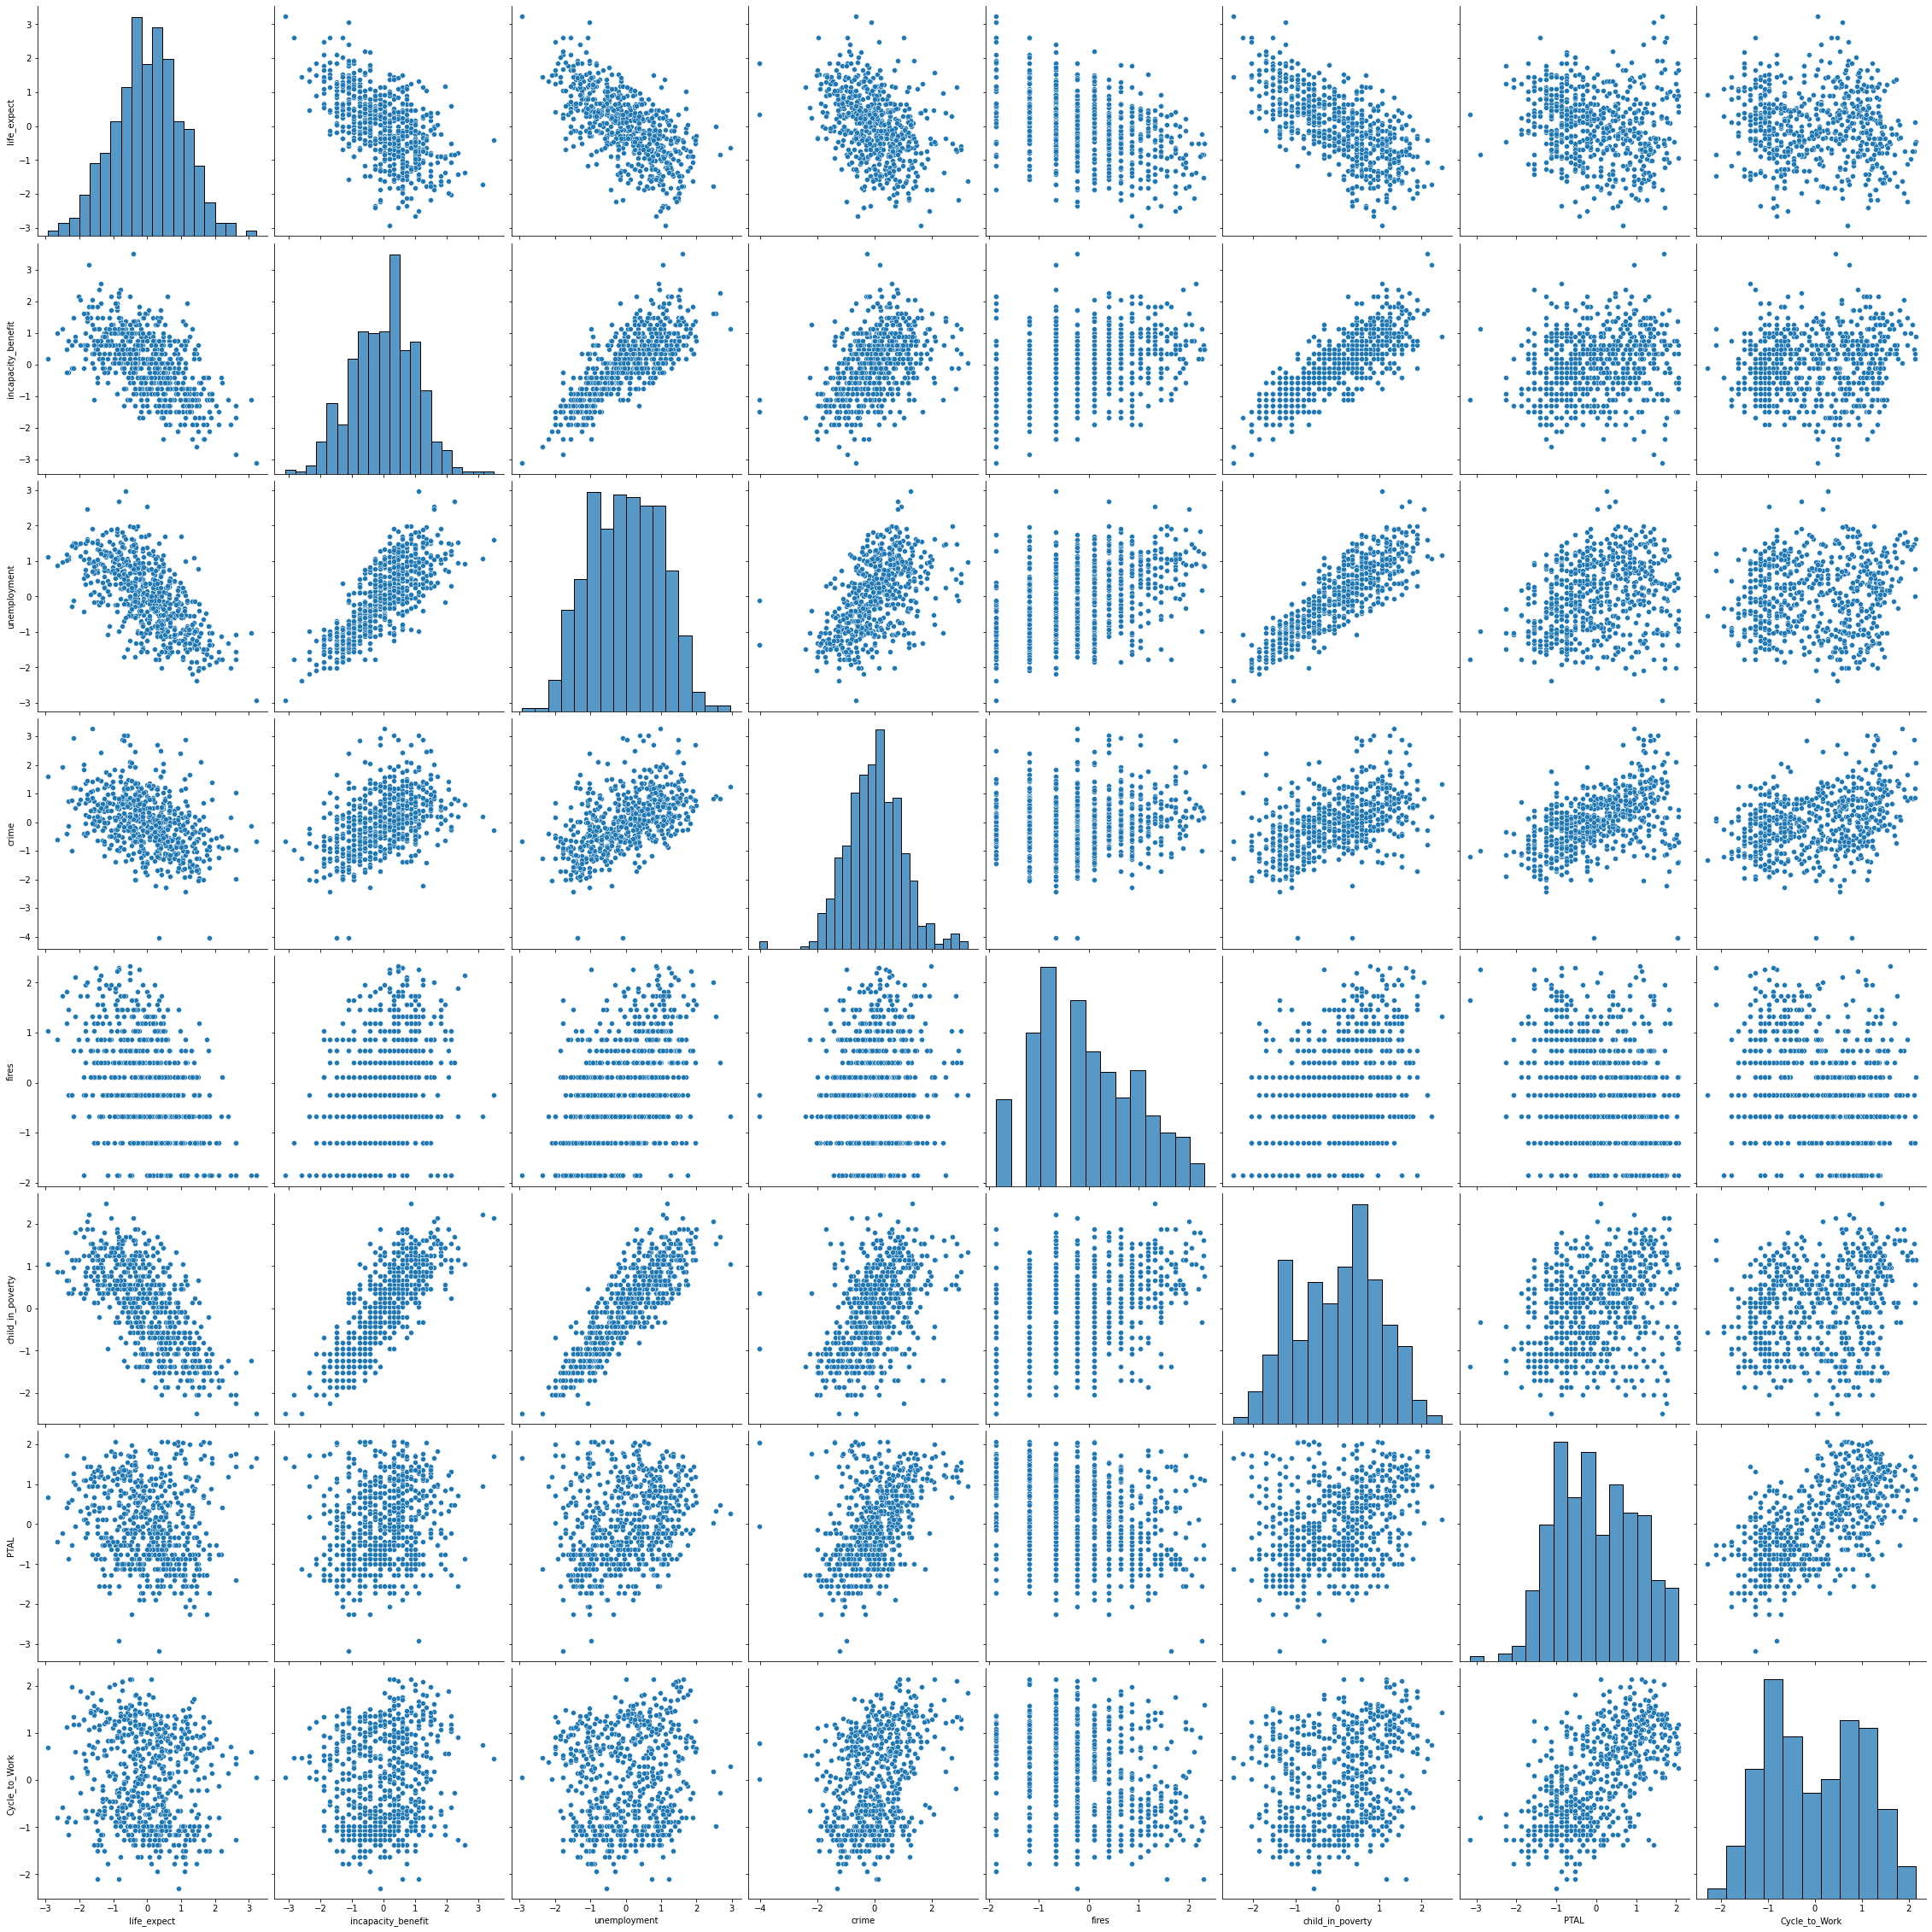

In [27]:
plot_norm = sns.pairplot(normed,height = 4)

In [28]:
rand_st_int = 10 
pca = PCA(random_state=rand_st_int)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.49316873 0.2312347  0.07296747 0.06676448 0.05395815 0.04367528
 0.02455819 0.013673  ]


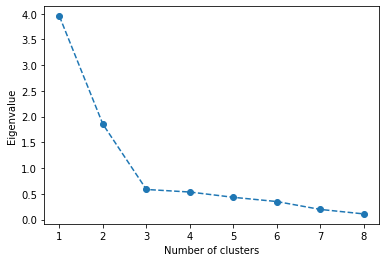

In [29]:
dfpc = pd.DataFrame({'eigenvalue':pca.explained_variance_,
             'PC':list(range(1, pca.n_components_ + 1))})

plt.plot(dfpc['PC'], dfpc['eigenvalue'], marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('Eigenvalue')
plt.show()

In [42]:
pca = PCA(n_components = 3)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.49316873 0.2312347  0.07296747]


In [43]:
list_var = normed.columns.tolist()
print(list_var)

['life_expect', 'incapacity_benefit', 'unemployment', 'crime', 'fires', 'child_in_poverty', 'PTAL', 'Cycle_to_Work']


In [44]:
df_PrincipleComp = pd.DataFrame(pca.components_, columns = list_var)
df_PrincipleComp

,life_expect,incapacity_benefit,unemployment,crime,fires,child_in_poverty,PTAL,Cycle_to_Work
0,0.390166,-0.430639,-0.457185,-0.341650,-0.232374,-0.467633,-0.205131,-0.147718
1,-0.150985,0.099998,0.117214,-0.246779,0.460220,0.056762,-0.571438,-0.592452
2,-0.115984,-0.448893,-0.205322,0.342197,0.725916,-0.207337,0.108671,0.209845


In [45]:
score_pca = pca.transform(normed)
score_pca

array([[ 2.42429437,  0.4054523 , -0.33980804],
       [ 2.62220734,  0.61723566,  0.62576474],
       [ 2.38997928, -0.08642267, -0.10130797],
       ...,
       [-2.32684648,  2.23216808, -0.35244112],
       [ 3.3273034 , -1.38627375, -0.23958941],
       [ 3.3273034 , -1.38627375, -0.23958941]])

In [46]:
print('Eigenvalues of each component:')
print(pca.explained_variance_)

Eigenvalues of each component:
[3.95166238 1.85283742 0.58467372]


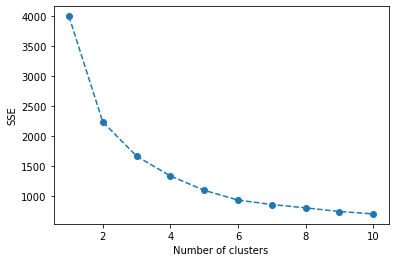

In [47]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='k-means++', random_state=0)
    km.fit(score_pca)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [48]:
k_cluster = 3
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(score_pca)

KMeans(n_clusters=3, random_state=1)

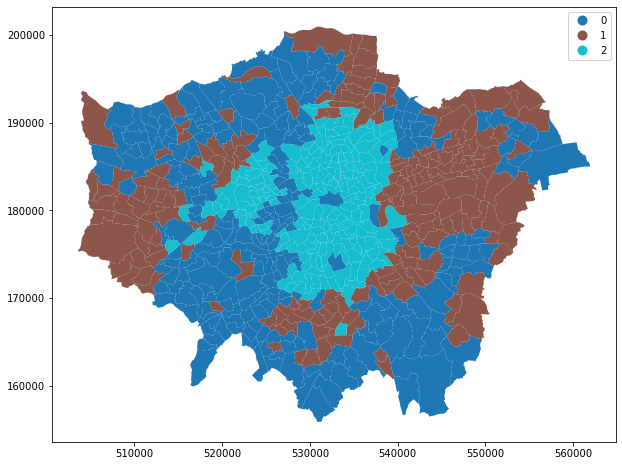

In [49]:
ppd['Kmeans_Cluster'] = kmeans_method.labels_
ppd.plot(column='Kmeans_Cluster', categorical=True, legend=True, figsize=(12,8));

In [50]:
ppd_kpca = pd.concat([ppd.reset_index(drop = True), pd.DataFrame(score_pca)],axis = 1)
ppd_kpca.columns.values[-3: ] = ['Component1','Component2','Component3']

In [51]:
ppd_kpca['Segement'] = ppd_kpca['Kmeans_Cluster'].map({0:'First',1:'Second',2:'Third',3:'Forth'})

In [52]:
ppd_kpca.head()

,NAME,GSS_CODE,geometry,life_expect,incapacity_benefit,unemployment,crime,fires,child_in_poverty,PTAL,Cycle_to_Work,Kmeans_Cluster,Component1,Component2,Component3,Segement
0,Chessington South,E05000405,"POLYGON ((516401.600 160201.800, 516407.300 16...",83.5,1.0,2.1,47.1,0.2,15.0,2.4,2.3,0,2.424294,0.405452,-0.339808,First
1,Tolworth and Hook Rise,E05000414,"POLYGON ((517829.600 165447.100, 517837.100 16...",83.5,0.6,2.6,46.4,0.4,12.0,2.3,2.9,0,2.622207,0.617236,0.625765,First
2,Berrylands,E05000401,"POLYGON ((518107.500 167303.400, 518114.300 16...",81.2,1.1,2.3,36.2,0.2,7.0,2.8,4.6,0,2.389979,-0.086423,-0.101308,First
3,Alexandra,E05000400,"POLYGON ((520480.000 166909.800, 520490.700 16...",85.2,0.6,2.1,43.9,0.2,7.0,2.2,3.9,0,3.554222,-0.015560,0.198995,First
4,Beverley,E05000402,"POLYGON ((522071.000 168144.900, 522063.900 16...",81.3,1.4,2.9,67.8,0.5,11.0,2.8,4.4,0,0.988641,0.155777,0.792074,First


/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


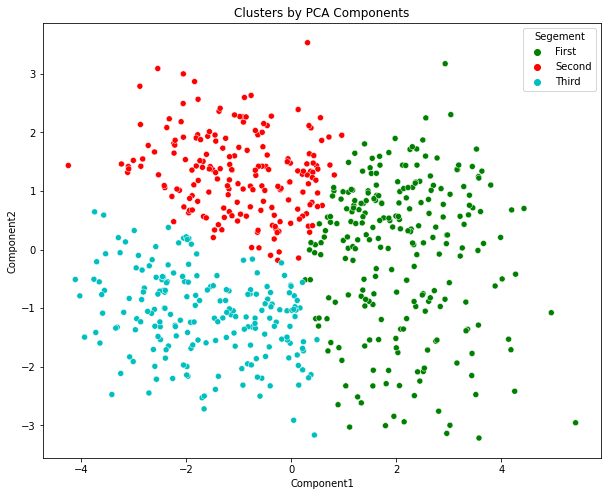

In [56]:
x_axis = ppd_kpca['Component1']
y_axis = ppd_kpca['Component2']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis,y_axis,hue = ppd_kpca['Segement'], palette = ['g','r','c'])
plt.title('Clusters by PCA Components')
plt.show()